# Practical: Data Analysis

In this assignment you will experiment with

- exploring the data collected at a home and a weather station around the Eindhoven area,
- building a predictive model for estimating the amount of electricity produced by the solar panels at the home given a weather forecast.

This notebook will guide you through the typical steps that such work would involve. It shows how to build a simple linear model and your task is to improve on it, i.e. train a model that will provide a more accurate prediction than the simple one.

#### Goal

Your task is to train a model on the time series data containing:

- measurements of the amount of electricity produced by the solar panels on the roof of a home in the Eindhoven area
- weather measurements around the Eindhoven airport

in order to predict the hourly solar panel output given the weather forecast for a particular hour of a particular day.

#### Jupyter notebooks

For those who are new to jupyter notebooks, a typical notebook contains text cells (like this one) interleaved with code cells (the gray boxes). You can execute a cell by selecting it and pressing Shift+Enter. The expression in the last line in a cell is the output of that cell. Try executing the following cell.

In [4]:
def add(a, b):
    return a + b

add(1,2)

3

You can find out more about jupyter notbooks at:

- https://jupyter-notebook-beginner-guide.readthedocs.io/en/latest/
- http://nbviewer.jupyter.org/github/jupyter/notebook/blob/master/docs/source/examples/Notebook/Notebook%20Basics.ipynb
- http://nbviewer.jupyter.org/github/jupyter/notebook/tree/master/docs/source/examples/Notebook/

#### References

The "Python Data Scinence Handbook" provides a good overview of using python for data data analysis and you are encouraged to consult it during this assignment:

- https://jakevdp.github.io/PythonDataScienceHandbook/

The "Introduction to Statistical Learning" [ISLR] (7th edition) book provides a good introduction to machine learning from the statistical perspective:

- http://faculty.marshall.usc.edu/gareth-james/ISL/

The "Dataset Shift in Machine Learning" book by Joaquin Quiñonero-Candela, Masashi Sugiyama, Anton Schwaighofer and Neil D. Lawrence provides a good overview of the problems that may arise when the test and training inputs and outputs have different distributions. You can find more information about the book at:

- https://mitpress.mit.edu/books/dataset-shift-machine-learning

#### Deliverable

Throughout this notebook you will find cells starting with `#TODO` and `#BEGIN_TODO`. Fill in all these TODO cells. The `#TODO` cells are meant to guide you, while the `#BEGIN_TODO` _answer cells_ will be graded.

- Answer cells start and end with tags, `# // BEGIN_TODO [Q0]` and `# // END_TODO [Q0]`, for example. Do not edit these tags in any way, else your answers may not be parsed by our grading system. 
- Your answers should be provided in Python code format between the tag lines, for example:
```
# // BEGIN_TODO [Q0]
q0 = 1
# // END_TODO [Q0]
```
- Do not place any other code between the tags, unless explicitly requested.
- Do not reuse the variable names from the answer cells, so do not use `q0`, `q1`, etc in other cells.
- If a question asks you to provide more than one answer, give the answer in the form of a list: `q0 = [1, 2]`. 

You are encouraged to play with the data and extend this notebook in order to obtain your answers. You may insert cells at any point in the notebook, as long as the question cells remain unaltered. At the end, deliver the filled in `assignment.ipynb` file.

> **IMPORTANT:** Before delivering your notebook, make sure that the cells in your notebook can be executed in sequence without errors, by executing "Restart & Run All" from the "Kernel" menu. This is also how your notebook will be evaluated.

Let's get started by filling in your details in the following answer cell. Assign your names and student ids to variables `name_student1`, `id_student1`, `name_student2`, `id_student2`, e.g.:

```
# // BEGIN_TODO [Q0]
name_student1 = "John Smith"
id_student1 = "1234567"
name_student2 = "Jane Miller"
id_student2 = "7654321"
# // END_TODO [Q0]
```

In [5]:
#// BEGIN_TODO [Q0]
name_student1 = "Bavo Coremans"
id_student1 = "0962143"
name_student2 = "Alan Wevers"
id_student2 = "0847167"
#// END_TODO [Q0]

### Import the relevant libraries

In this assignment we will be using mainly the following libraries:

- `pandas` for organizing the data
- `numpy` for operating on the data
- `matplotlib` for visualizing the data
- `sklearn` for training and evaluating a model on the data
- other utility libraries

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.linear_model import *
from sklearn.metrics import *
from sklearn.model_selection import *
import glob

### Read the data

The data resides in two files:

In [7]:
# raw_energy = pd.read_csv("./data/energy_train.csv", dtype={"date": str, "time": str, "seconds": int, "total_consumption": float, "total_production": float, "solar_production": float, "total_solar_production": float, "year": int})
raw_energy = pd.read_csv("./data/energy_train.csv", low_memory=False)
raw_energy.head()

,date,time,seconds,total_consumption,total_production,solar_production,total_solar_production,year
0,2017-01-01,01:00:01,1483228801,13188.301,4499.785,0,4147.1,2017
1,2017-01-01,01:00:11,1483228811,13188.302,4499.785,0,4147.1,2017
2,2017-01-01,01:00:21,1483228821,13188.304,4499.785,0,4147.1,2017
3,2017-01-01,01:00:31,1483228831,13188.305,4499.785,0,4147.1,2017
4,2017-01-01,01:00:41,1483228841,13188.307,4499.785,0,4147.1,2017


In [8]:
raw_weather = pd.read_csv("./data/weather_train.csv")
raw_weather.head()

,time,clouds,temperature,humidity,wind direction,wind speed,visibility,air pressure,year
0,2017-01-01T00:00:00Z,0,-1.7,99.0,ZZW,3.0,197.0,1026.0,2017
1,2017-01-01T00:10:00Z,0,-1.7,99.0,ZZW,3.0,195.0,1025.8,2017
2,2017-01-01T00:20:00Z,0,-1.7,99.0,ZZW,3.0,271.0,1025.6,2017
3,2017-01-01T00:30:00Z,0,-1.6,99.0,Z,3.0,316.0,1025.4,2017
4,2017-01-01T00:40:00Z,0,-1.6,99.0,Z,3.0,334.0,1025.3,2017


When analysing data it is important to understand its semantics. In IoT one needs to be extra careful, especially when integrating data from various sources. The very basic information are the units of the measurements, but also the specifications of the sensors gathering the data and the processes that are being monitored. For example, in this case the specification of the solar panel installation states that it can generate max 153k Jouls per minute.  

Assume the following for the energy data:
- `seconds` is the time the sample was recorded (UTC)
- `total_consumption` is the total amount of electricity that was pulled from the grid (kWh)
- `total_production` is the total amount of electricity that was pushed into the grid (kWh)
- `solar_production` is the amount of eletricity that was produced since the last sample (Wh).
- `total_solar_production` is the total amount of electricity produced by the solar panels (kWh)

Assume the following for the weather data:
- `time` is the time the sample was recorded (UTC)
- `clouds` measures whether it was cloudy at the time when the sample was taken, ranging from 0-3, 0 meaning very cloudy and 3 meaning no clouds.
- `temperature` is the still temperature (C)
- ...

### Explore the data

Exploration is usually the first step in any data analysis task. Visualization is an important tool for exploring the data. It gives insights into the structure and semantics of the data and indications for how to clean it.

The `matplotlib` library provides a collection of useful plots, such as a line plot, scatter plot, histogram, scatter mattrix, etc. You can find out more about this library at 

- https://matplotlib.org/users/pyplot_tutorial.html
- https://matplotlib.org/devdocs/gallery/

The `pandas` library also contains convenient wrappers around the `matplotlib` library for visualizing data frames and series:

- https://pandas.pydata.org/pandas-docs/stable/visualization.html

Let's draw a simple plot of the energy data:

[1483228801, 1527206393, 0.0, 8078.8]

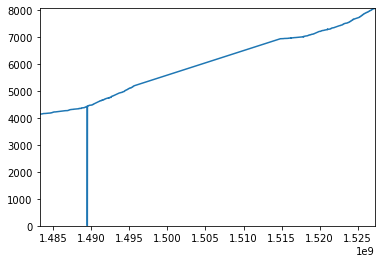

In [9]:
X = raw_energy["seconds"]
Y = raw_energy["total_solar_production"]
plt.plot(X, Y)
plt.axis([X.min(), X.max(), Y.min(), Y.max()])

total production


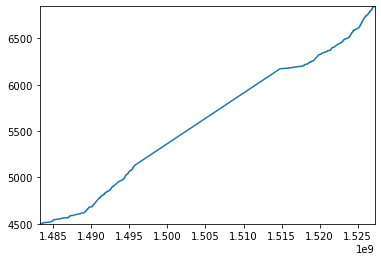

total consumtion


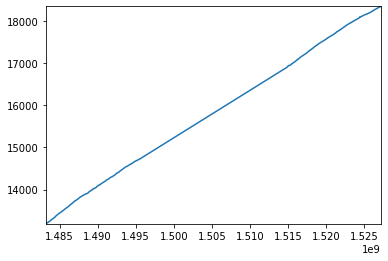

solar_production


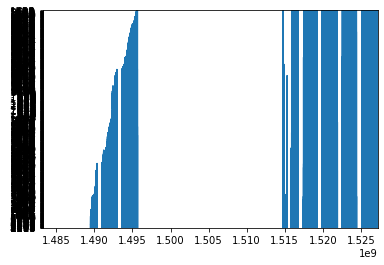

In [10]:
# TODO: explore the values in different columns (experiment with different visualizations, e.g. line, histogram, ...)
print('total production')
X = raw_energy["seconds"]
Y = raw_energy["total_production"]
plt.plot(X, Y)
plt.axis([X.min(), X.max(), Y.min(), Y.max()])
plt.show()
print('total consumtion')
X = raw_energy["seconds"]
Y = raw_energy["total_consumption"]
plt.plot(X, Y)
plt.axis([X.min(), X.max(), Y.min(), Y.max()])
plt.show()
print('solar_production')
X = raw_energy["seconds"]
Y = raw_energy["solar_production"]
plt.plot(X, Y)
plt.axis([X.min(), X.max(), Y.min(), Y.max()])
plt.show()


### Question 1

Simple visual inspection of the data can already tell you a lot about what you are working with. The data covers all of 2017 and 2018, because the data was split into training and test sets, some time ranges will be missing. Assign to `question_missing_months` below the numbers of the months that are missing from the training set (1 for January, 2 for February, ..., 12 for December). You will probably have to convert UTC timestamps.

c:\program files\python\python38\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


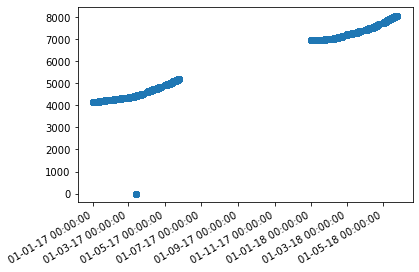

In [11]:
#// BEGIN_TODO [Q1]
# import time
import matplotlib.dates as mdates

# datetimes = []
# for x in raw_energy['seconds']:
#     datetimes.append(time.strftime('%Y-%m-%d %H:%M:%S', x))
    
secs = mdates.epoch2num(raw_energy['seconds'])

fig, ax = plt.subplots()

# Plot the date using plot_date rather than plot
ax.plot_date(secs, raw_energy["total_solar_production"])

# Choose your xtick format string
date_fmt = '%d-%m-%y %H:%M:%S'

# Use a DateFormatter to set the data to the correct format.
date_formatter = mdates.DateFormatter(date_fmt)
ax.xaxis.set_major_formatter(date_formatter)

# Sets the tick labels diagonal so they fit easier.
fig.autofmt_xdate()

plt.show()

# X = datetimes
# Y = raw_energy["total_solar_production"]
# plt.plot(X, Y)

question_missing_months = [6,7,8,9,10,11,12]
#// END_TODO [Q1]

### Clean the data

Data cleaning is an important part of any data analysis task. According to the general wisdom, most effort actually is spent on data cleaning. It involves preparing the data for the following steps, e.g. converting values to the right type, filling in missing values, removing outliers, normalizing the data, etc.

In the plot above you will have noticed vertical lines. These lines correspond to 0 values and are likely to be measuring errors (e.g. the solar panel meter has crashed). Such outliers will often negatively impact the accuracy of the predictive model. However, care must be taken to properly define what constitutes an outlier and what constitutes a valid measurement. Some odd looking measurements may actually contain important evidence for proving or disproving a hypothesis. In this case the 0 values can be considered measurement errors and should be removed.

Pandas provides convenient methods for selecting subsets of the data that can be used for removing outliers:

- https://jakevdp.github.io/PythonDataScienceHandbook/03.02-data-indexing-and-selection.html

In [12]:
# TODO: remove the samples with production total of 0
# raw_energy["total_solar_production"]
indexNames = raw_energy[ raw_energy["total_solar_production"] == 0 ].index

print(indexNames)
# Delete these row indexes from dataFrame
raw_energy.drop(indexNames , inplace=True)


Int64Index([497501, 497502, 497503, 497504, 497505, 497506, 497507, 497508,
            497509, 497510, 497511, 497512, 497513, 497514, 497515, 497516,
            497517, 497518, 497519, 497520, 497521, 497522, 497523, 497524,
            497525, 497526, 497527, 497528, 497529, 497530, 497531, 497532,
            497533, 497534, 497535, 497536, 497537, 497538, 497539, 497540,
            497541, 497542, 497543, 497544, 497545, 497546, 497547, 497548,
            497549, 497550, 497551, 497552, 497553, 497554, 497555, 497556,
            497557, 497558, 497559, 497560, 497561, 497562, 497563, 497564,
            497565, 497566, 497567, 497568, 497569, 497570, 497571, 497572,
            497573, 497574, 497575, 497576, 497577, 497578, 497579, 497580,
            497581, 497582, 497583, 497584, 497585, 497586, 497587, 497588,
            497589, 497590, 497591, 497592, 497593, 497594, 497595, 497596,
            497597],
           dtype='int64')


Data that is collected in the wild will sometimes contain formatting inconsistencies. It is a good habit to check the data types:

In [13]:
raw_energy.dtypes

date                       object
time                       object
seconds                     int64
total_consumption         float64
total_production          float64
solar_production           object
total_solar_production    float64
year                        int64
dtype: object

As expected, the `'total_consumption'`, `'total_production'`, `'total_solar_production'` columns are of numerical type, however, the `solar_production` is of an `object` type (which is also used for strings), while looking at the specification of the column above we would expect a numerical type. Modeling this column later will require a numerical column, so it will need to be converted to the right type first.

In [14]:
# TODO: explore the offending values in the solar_production column
# df = raw_energy[raw_energy['solar_production'].applymap(np.isreal)]
# print(raw_energy["solar_production"][~np.isnan(x).any(axis=1)])
# print(df)
for x in raw_energy['solar_production']:
    if np.char.isnumeric(x) == False:
        print(x)

 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 

 859
 859
 859
 859
 859
 859
 859
 859
 859
 859
 859
 859
 859
 859
 859
 859
 859
 859
 859
 859
 859
 859
 859
 859
 859
 859
 859
 889
 889
 889
 889
 889
 889
 889
 889
 889
 889
 889
 889
 889
 889
 889
 889
 889
 889
 889
 889
 889
 889
 889
 889
 889
 889
 889
 889
 889
 889
 889
 889
 889
 889
 889
 972
 972
 972
 972
 972
 972
 972
 972
 972
 972
 972
 972
 972
 972
 1119
 1119
 1119
 1119
 1119
 1119
 1119
 1119
 1119
 1119
 1119
 1119
 1119
 1119
 1119
 1119
 1119
 1119
 1119
 1119
 1119
 1118
 1118
 1118
 1118
 1118
 1118
 1118
 1118
 1118
 1118
 1118
 1118
 1118
 1118
 1118
 1118
 1118
 1118
 1118
 1118
 1118
 1118
 1118
 1118
 1118
 1118
 1118
 1118
 1296
 1296
 1296
 1296
 1296
 1296
 1296
 1599
 1599
 1599
 1599
 1599
 1599
 1599
 1599
 1599
 1599
 1599
 1599
 1599
 1599
 1599
 1599
 1599
 1599
 1599
 1599
 1599
 1599
 1599
 1599
 1599
 1599
 1599
 1599
 1599
 1599
 1599
 1599
 1599
 1599
 1599
 1599
 1599
 1599
 1599
 1599
 1599
 1599
 1599
 1599
 1599
 1599
 1599
 1

 1389
 1389
 1389
 1389
 1389
 1389
 1389
 1389
 1389
 1389
 1389
 1389
 1389
 1389
 1389
 1389
 1389
 1389
 1389
 1389
 1389
 1389
 1389
 1389
 1389
 1389
 1389
 1389
 1389
 1389
 1389
 1389
 1389
 1389
 1389
 1389
 1389
 1389
 1389
 1389
 1389
 1389
 1389
 1389
 1389
 1389
 1389
 1389
 1389
 1389
 1389
 1389
 1389
 1389
 1389
 1389
 1389
 1389
 1389
 1389
 1389
 1389
 1389
 1389
 1389
 1389
 1389
 1389
 1389
 1389
 1389
 1389
 1389
 1389
 1389
 1389
 1389
 1389
 1389
 1389
 1389
 1389
 1389
 1389
 1389
 1389
 1389
 1389
 1389
 1389
 1389
 1389
 1389
 1389
 1389
 1389
 1389
 1389
 1389
 1389
 1389
 1389
 1389
 1389
 1389
 1389
 1389
 1389
 1389
 1389
 1389
 1389
 1389
 1389
 1389
 1389
 1389
 1389
 1389
 1389
 1389
 1389
 1389
 1389
 1389
 1389
 1389
 1389
 1389
 1389
 1389
 1389
 1389
 1389
 1389
 1389
 1389
 1389
 1389
 1389
 1389
 1389
 1389
 1389
 1389
 1389
 1389
 1389
 1389
 1389
 1389
 1389
 1389
 1389
 1389
 1389
 1389
 1389
 1389
 1389
 1389
 1389
 1389
 1389
 1389
 1389
 138

 349
 349
 349
 349
 349
 349
 349
 349
 349
 349
 296
 296
 296
 296
 296
 296
 296
 296
 296
 296
 296
 296
 296
 296
 296
 296
 296
 296
 296
 296
 296
 296
 296
 296
 296
 296
 296
 296
 296
 296
 296
 296
 296
 296
 296
 281
 281
 281
 281
 281
 281
 281
 281
 281
 281
 281
 281
 281
 281
 281
 281
 281
 281
 281
 281
 281
 281
 281
 281
 281
 281
 281
 281
 294
 294
 294
 294
 294
 294
 294
 294
 294
 294
 294
 294
 294
 294
 294
 294
 294
 294
 294
 294
 294
 294
 294
 294
 294
 294
 294
 294
 294
 294
 294
 294
 294
 294
 294
 306
 306
 306
 306
 306
 306
 306
 306
 306
 306
 306
 306
 306
 306
 306
 306
 306
 306
 306
 306
 306
 306
 306
 306
 306
 306
 306
 306
 505
 505
 505
 505
 505
 505
 505
 505
 505
 505
 505
 505
 505
 505
 505
 505
 505
 505
 505
 505
 505
 505
 505
 505
 505
 505
 505
 505
 505
 505
 505
 505
 505
 505
 505
 618
 618
 618
 618
 618
 618
 618
 618
 618
 618
 618
 618
 618
 618
 618
 618
 618
 618
 618
 618
 618
 618
 618
 618
 618
 618
 618
 618
 450


 660
 660
 660
 660
 660
 660
 660
 660
 660
 660
 660
 660
 660
 660
 660
 660
 660
 660
 660
 660
 660
 660
 290
 290
 290
 290
 290
 290
 290
 290
 290
 290
 290
 290
 290
 290
 290
 290
 290
 290
 290
 290
 290
 290
 290
 290
 290
 290
 290
 290
 326
 326
 326
 326
 326
 326
 326
 326
 326
 326
 326
 326
 326
 326
 326
 326
 326
 326
 326
 326
 326
 326
 326
 326
 326
 326
 326
 326
 326
 326
 326
 326
 326
 326
 326
 752
 752
 752
 752
 752
 752
 752
 752
 752
 752
 752
 752
 752
 752
 752
 752
 752
 752
 752
 752
 752
 752
 752
 752
 752
 752
 752
 752
 246
 246
 246
 246
 246
 246
 246
 246
 246
 246
 246
 246
 246
 246
 246
 246
 246
 246
 246
 246
 246
 246
 246
 246
 246
 246
 246
 246
 332
 332
 332
 332
 332
 332
 332
 332
 332
 332
 332
 332
 332
 332
 332
 332
 332
 332
 332
 332
 332
 332
 332
 332
 332
 332
 332
 332
 332
 332
 332
 332
 332
 332
 332
 282
 282
 282
 282
 282
 282
 282
 282
 282
 282
 282
 282
 282
 282
 282
 282
 282
 282
 282
 282
 282
 282
 282
 282


 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 

 71
 71
 71
 71
 71
 71
 71
 71
 71
 71
 71
 71
 71
 71
 71
 71
 71
 71
 71
 71
 71
 71
 71
 71
 71
 71
 71
 71
 108
 108
 108
 108
 108
 108
 108
 108
 108
 108
 108
 108
 108
 108
 108
 108
 108
 108
 108
 108
 108
 108
 108
 108
 108
 108
 108
 108
 108
 108
 108
 108
 108
 108
 108
 108
 68
 68
 68
 68
 68
 68
 68
 68
 68
 68
 68
 68
 68
 68
 68
 68
 68
 68
 68
 68
 68
 68
 68
 68
 68
 68
 68
 68
 85
 85
 85
 85
 85
 85
 85
 85
 85
 85
 85
 85
 85
 85
 85
 85
 85
 85
 85
 85
 85
 85
 85
 85
 85
 85
 85
 85
 85
 85
 85
 85
 85
 85
 85
 73
 73
 73
 73
 73
 73
 73
 73
 73
 73
 73
 73
 73
 73
 73
 73
 73
 73
 73
 73
 73
 73
 73
 73
 73
 73
 73
 73
 72
 72
 72
 72
 72
 72
 72
 72
 72
 72
 72
 72
 72
 72
 72
 72
 72
 72
 72
 72
 72
 72
 72
 72
 72
 72
 72
 72
 72
 72
 72
 72
 72
 72
 72
 96
 96
 96
 96
 96
 96
 96
 96
 96
 96
 96
 96
 96
 96
 96
 96
 96
 96
 96
 96
 96
 96
 96
 96
 96
 96
 96
 96
 95
 95
 95
 95
 95
 95
 95
 95
 95
 95
 95
 95
 95
 95
 95
 95
 95
 95
 95
 95
 95
 95
 95


 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 

 509
 509
 509
 509
 509
 509
 509
 509
 509
 509
 509
 509
 509
 509
 509
 509
 509
 509
 509
 509
 509
 509
 509
 509
 509
 509
 582
 582
 582
 582
 582
 582
 582
 582
 582
 582
 582
 582
 582
 582
 582
 582
 582
 582
 582
 582
 582
 582
 582
 582
 582
 582
 582
 582
 610
 610
 610
 610
 610
 610
 610
 610
 610
 610
 610
 610
 610
 610
 610
 610
 610
 610
 610
 610
 610
 610
 610
 610
 610
 610
 610
 610
 610
 610
 610
 610
 610
 610
 610
 686
 686
 686
 686
 686
 686
 686
 686
 686
 686
 686
 686
 686
 686
 686
 686
 686
 686
 686
 686
 686
 686
 686
 686
 686
 686
 686
 686
 787
 787
 787
 787
 787
 787
 787
 787
 787
 787
 787
 787
 787
 787
 787
 787
 787
 787
 787
 787
 787
 787
 787
 787
 787
 787
 787
 787
 787
 787
 787
 787
 787
 787
 787
 937
 937
 937
 937
 937
 937
 937
 937
 937
 937
 937
 937
 937
 937
 937
 937
 937
 937
 937
 937
 937
 937
 937
 937
 937
 937
 937
 937
 1112
 1112
 1112
 1112
 1112
 1112
 1112
 1112
 1112
 1112
 1112
 1112
 1112
 1112
 1112
 1112
 111

 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 

 813
 813
 813
 813
 813
 813
 813
 813
 813
 813
 813
 813
 813
 813
 813
 813
 813
 813
 813
 813
 813
 813
 813
 813
 813
 879
 879
 879
 879
 879
 879
 879
 879
 879
 879
 879
 879
 879
 879
 879
 879
 879
 879
 879
 879
 879
 879
 879
 879
 879
 879
 879
 879
 879
 879
 879
 879
 879
 879
 879
 1277
 1277
 1277
 1277
 1277
 1277
 1277
 1277
 1277
 1277
 1277
 1277
 1277
 1277
 1277
 1277
 1277
 1277
 1277
 1277
 1277
 1277
 1277
 1277
 1277
 1277
 1277
 1277
 1239
 1239
 1239
 1239
 1239
 1239
 1239
 1239
 1239
 1239
 1239
 1239
 1239
 1239
 1239
 1239
 1239
 1239
 1239
 1239
 1239
 1239
 1239
 1239
 1239
 1239
 1239
 1239
 1652
 1652
 1652
 1652
 1652
 1652
 1652
 1652
 1652
 1652
 1652
 1652
 1652
 1652
 1652
 1652
 1652
 1652
 1652
 1652
 1652
 1652
 1652
 1652
 1652
 1652
 1652
 1652
 1652
 1652
 1652
 1652
 1652
 1652
 1652
 1717
 1717
 1717
 1717
 1717
 1717
 1717
 1717
 1717
 1717
 1717
 1717
 1717
 1717
 1717
 1717
 1717
 1717
 1717
 1717
 1717
 1717
 1717
 1717
 1717
 171

 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 

### Question 2

Convert empty strings in the `'solar_production'` column to `np.nan`.

In [15]:
#// BEGIN_TODO [Q2]

raw_energy["solar_production"].replace('', np.NaN)
raw_energy["solar_production"].replace(' ', np.NaN)

#// END_TODO [Q2]

0          0
1          0
2          0
3          0
4          0
          ..
1987359    0
1987360    0
1987361    0
1987362    0
1987363    0
Name: solar_production, Length: 1987267, dtype: object

### Question 3

Convert the remaining values in the `'solar_production'` column to `float` type.

In [16]:
#// BEGIN_TODO [Q3]

raw_energy['solar_production'] = pd.to_numeric(raw_energy['solar_production'], errors='coerce')
raw_energy['solar_production'] = raw_energy['solar_production'].astype(float)

#// END_TODO [Q3]

### Engineer features

The goal of this assignment is to predict the hourly energy output of the solar panels given the weather forecast. This requires to relate the energy samples with the weather samples, basically attaching the energy production label to the weather measurements. However, the *total* energy and weather samples are taken approximately every 10 seconds and 10 minutes, respectively.

####  Aggregate per hour

We can use pandas grouping functions to aggregate the samples per hour, taking the largest  measurement in that hour.

In [17]:
col = "total_solar_production"
energy = raw_energy.copy()
times = pd.to_datetime(energy["seconds"], unit='s')

energy = energy.groupby([times.dt.year, times.dt.month, times.dt.dayofyear, times.dt.hour])[[col]].agg(np.max)
energy.index.names = ["year", "month", "day", "hour"]

### Question 4 ###

Note that the hourly aggregation using the maximum works well for columns containing the totals. Does it also work for the `'solar_production'` column?

1. Yes, but the aggregation method needs to be changed to fit the solar_production data type
2. Yes, the same aggregation method can be applied
3. No, it's not possible to aggegrate over the solar_production field
4. No, aggregating over the solar_production field in any way does not make sense.
5. None of the above.

Assign an integer corresponding to the correct answer to variable `question_aggregation`.

In [18]:
#// BEGIN_TODO [Q4]
question_aggregation = 1
#// END_TODO [Q4]

After aggregation, some cells can contain `Nan` values (e.g. when trying to compute a maximum for an hour during which no samples were recorded). Therefore, after performing such operations one should decide what to do with any NaN values. In this case we chose to remove such samples.

In [19]:
energy = energy.dropna()

After grouping, merging and slicing operations, the index of a data frame might need to be recomputed, to reflect the new ordering of rows.

In [20]:
energy = energy.reset_index()

#### Compute the hourly production

We are interested in predicting the solar panel output in a given hour. However, the `'total_solar_production'` column in the energy data frame at this point contains the total solar panel output until the end of that hour. Assuming that the data set contains a sample for every hour, i.e. there are no gaps, the hourly output can be compouted by taking the difference between the previous sample.

In [21]:
energy["production"] = energy[col] - energy[col].shift(1)
energy = energy.dropna().reset_index()
energy.head()

,index,year,month,day,hour,total_solar_production,production
0,1,2017,1,1,1,4147.1,0.0
1,2,2017,1,1,2,4147.1,0.0
2,3,2017,1,1,3,4147.1,0.0
3,4,2017,1,1,4,4147.1,0.0
4,5,2017,1,1,5,4147.1,0.0


### Question 5 ###

After creating the production column there are NaNs in the data. Where do they come from, and why is the index recomputed?

1. The NaN values are caused by missing values in the original data due to sensor errors, and the index is reset because a column has been added.
2. The NaN values are caused by missing values in the original data due to the way the column is calculated, and the index is reset because a column has been added.
3. The NaN values are caused by missing values in the original data due to sensor errors, and the index is reset because the number of rows has changed.
4. The NaN values are caused by missing values in the original data due to the way the column is calculated, and the index is reset because the number of rows has changed.

Assign an integer corresponding to the correct answer to variable `question_production`.

In [22]:
#// BEGIN_TODO [Q5]
question_production = 1
#// END_TODO [Q5]

Now we can perform a similar aggregation for the `clouds` column in the weather data. Note that rather than choosing the maximum, we take the average `clouds` value per hour.

In [23]:
weather = raw_weather.copy()
times = pd.to_datetime(weather["time"])
weather = weather.groupby([times.dt.year, times.dt.month, times.dt.dayofyear, times.dt.hour])["clouds"].agg(np.mean)
weather.index.names = ["year", "month", "day", "hour"]
weather = weather.reset_index()

#### Merge the data frames

Now that both data frames are expressed in terms of hours and the energy data frame contains the hourly solar panel output, we can use pandas to merge them.

**Important:** when dealing with times in data from various sources one must be very carefull about the semantics of the time, such as the time-zone or the daylight-saving. Luckily, in this assignment both energy and weather data use UTC time, so no extra preprocessing is required.

In [24]:
data = pd.merge(energy, weather).dropna().reset_index(drop=True)
data.head()

,index,year,month,day,hour,total_solar_production,production,clouds
0,1,2017,1,1,1,4147.1,0.0,0.0
1,2,2017,1,1,2,4147.1,0.0,0.0
2,3,2017,1,1,3,4147.1,0.0,0.0
3,4,2017,1,1,4,4147.1,0.0,0.0
4,5,2017,1,1,5,4147.1,0.0,0.0


#### Explore the engineered features

After engineering features it is a good idea to explore the data set again, to see if extra cleaning is required.

0.0 87.39999999999964


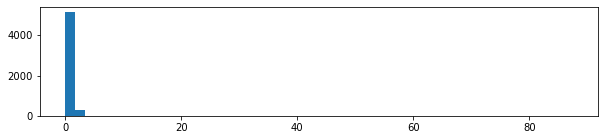

In [26]:
values = data["production"].values
plt.figure(figsize=(10, 2))
plt.hist(values, 50);
print (min(values), max(values))

The small variance of the values and their large range suggests there are some outliers. This can be also visualized in a different way.

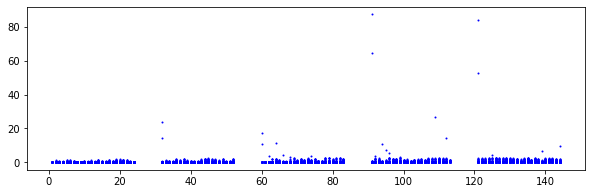

In [27]:
def plot(df, col):
    x = df["day"]
    plt.figure(figsize=(10,3))
    plt.plot(x, df[col], 'bo', markersize=1)

plot(data, "production")

The figure suggests that there are indeed outliers in the energy production data.

### Question 6

The plot shows some outliers. How do you explain these? Choose all correct answers.

1. There is actually an oversight in the previous calculations which causes the outliers.
2. There is some unclean data present due to sensor errors.
3. There were some very clear and sunny days.
4. The outliers represent multiple days of production.

Assign a list of integers corresponding to the correct answers to variable `question_outliers`.

In [28]:
#// BEGIN_TODO [Q6]
question_outliers = 2
#// END_TODO [Q6]

Note that when removing the energy samples containing 0 values in `raw_energy` earlier, it was clear how to define an outlier. In this case, however, one must carefully decide how to define an outlier, to avoid introducing bias. You can read more about outlier detection here:

- Section 3.3.3 of "Introduction to Statistical Learning"
- http://scikit-learn.org/stable/modules/outlier_detection.html

### Question 7

How do you best define an outlier for this data set?

1. Calculate the average production, and define an outlier based on standard deviations.
2. Build a model for the expected production, and label outliers based on the model predictions.
3. Set a fixed threshold for outliers based on the characteristics of the solar panels.
4. Estimate a fixed threshold for outliers by hand based on the above plot.

Assign an integer corresponding to the correct answer to variable `question_outlier_definition`.

In [29]:
#// BEGIN_TODO [Q7]
question_outlier_definition = 3
#// END_TODO [Q7]

### Question 8

Remove the outliers from the `data` data frame. Assign the resulting data frame to variable `data_no_outliers`. 

In [30]:
#// BEGIN_TODO [Q8]
from scipy import stats

z = np.abs(stats.zscore(data))
print(z)
print("sdkfjsldkjfldskfjldskfjsdlkfjldskfj")
threshold = 3
print(np.where(z > 3))
print("##########")
Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1
print(IQR)
print("##########before")
print(data.shape)
print("##########")
data_no_outliers = data[(z < 3).all(axis=1)]
print("##########after")
print(data_no_outliers.shape)
# data_no_outliers = data
#// END_TODO [Q8]

[[1.71760092 0.98632944 1.42144328 ... 1.23146975 0.17728544 0.83356994]
 [1.71697759 0.98632944 1.42144328 ... 1.23146975 0.17728544 0.83356994]
 [1.71635426 0.98632944 1.42144328 ... 1.23146975 0.17728544 0.83356994]
 ...
 [1.72567435 1.01386003 1.3810694  ... 1.4769914  4.29016395 0.83356994]
 [1.72629768 1.01386003 1.3810694  ... 1.4769914  0.17728544 0.83356994]
 [1.72692101 1.01386003 1.3810694  ... 1.4769914  0.17728544 0.83356994]]
sdkfjsldkjfldskfjldskfjsdlkfjldskfj
(array([ 570, 1063, 1076, 1167, 1639, 1731, 1751, 2087, 2191, 3302, 4345,
       4870, 4873, 5446], dtype=int64), array([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6], dtype=int64))
##########
index                     2802.000000
year                         1.000000
month                        2.000000
day                         72.000000
hour                        12.000000
total_solar_production    2853.600000
production                   0.300000
clouds                       2.166667
dtype: float64
##########be

Data visualization is often helpful to check if the results of our data processing and analysis meet our expectations.

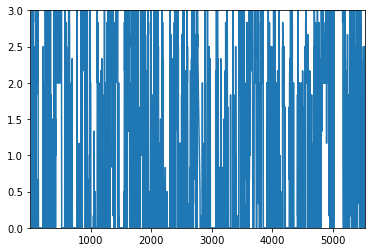

In [31]:
# TODO: plot the clouds feature
X = data["index"]
Y = data["clouds"]
plt.plot(X, Y)
plt.axis([X.min(), X.max(), Y.min(), Y.max()])
plt.show()

### Train a model

For training and evaluating the perfromance of a model we need to split the data into a training and a test.

In [32]:
X = data[["clouds"]].values
y = data["production"].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [33]:
model = LinearRegression().fit(X_train, y_train)

### Evaluate the model

After a model is trained we would like to estimate how well it is performing, whether we can actually trust its predictions if it were deployed. Model performance can be estimated using various visualisations and statistics (see Section 3.1.3 of [ISLR])

#### Model fit

If the feature space is 1 or 2 dimensional, then we can easily plot the model to illustrate how well it fits the test data.

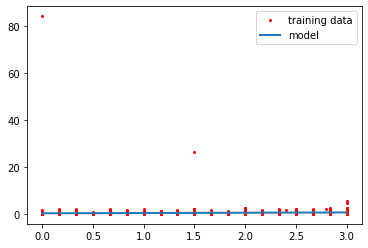

In [34]:
x_plot = np.linspace(min(X), max(X), 100)
X_plot = x_plot.reshape(-1, 1)
y_plot = model.predict(X_plot)

dots, = plt.plot(X_test, y_test, 'bo', markersize=2, color="red", label="training data");
line, = plt.plot(x_plot, y_plot, linewidth=2, label="model");
plt.legend(handles=[dots, line]);

We can compute the R2 score to assign a number to how well the model fits the data. It estimates how much of the variance in the data is explained by the model, i.e. how well the model fits the data. A score of 1 means the model captures all of the variance, and a score of 0 means the model does not capture any of the variance.

You can read more about the R2 score in Section 3.1.3 of "Introduction to Statistical Learning".

In [35]:
model.score(X_test, y_test)

-0.00010775710528143634

#### Residuals

We can also plot a histogram of the residuals (or errors), i.e. the deviations of the values predicted by our model from the ground truth values (from the test set):

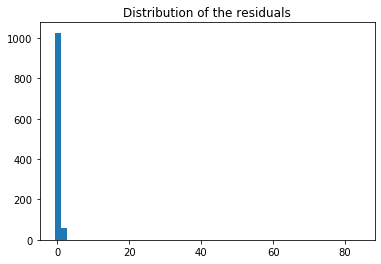

In [36]:
y_pred = model.predict(X_test)
plt.title("Distribution of the residuals")
plt.hist(y_test - y_pred, 50);

Looking at the histogram you will notice that distribution of the residuals is not symmetric.

### Question 9

Does the model tend to over-estimate, or under-estimate the solar panel output?

1. The model tends to over-estimate.
2. The model tends to under-estimate.
3. The model is not biased

Assign an integer corresponding to the correct answer to variable `question_bias`. 

In [37]:
#// BEGIN_TODO [Q9]
question_bias = 2
#// END_TODO [Q9]

If the model is not biased, or if we are not interested in the bias, then we can compute the mean absolute deviation (MAD) to estimate the expected error of a prediction. E.g. a MAD = 0.345 means that we expect on average our predition to be off by 0.345kWh.

In [38]:
y_pred = model.predict(X_test)
mean_absolute_error(y_test, y_pred)

0.5242253226592938

### Improve the model

We have shown here a simple linear model mapping the `clouds` feature to the `hourly_production` label. However, this model does not perform very well. The problem could be that the model is underfitting or overfitting the data. You can find more about under- and overfitting in Section 2.1.2, 2.1.3, 6.1 of "Introduction to Statistical Learning", 7th edition.

### Question 10 ###

Is the model underfitting or overfitting the training data? What makes you say that?

1. The model is underfitting. This can be seen by the straightness of the line of the model in the plot.
2. The model is underfitting. This can be seen by the location of the line of the model in the plot.
3. The model is overfitting. This can be seen by the straightness of the  line of the model in the plot.
4. The model is overfitting. This can be seen by the location of the line of the model in the plot.

Assign an integer corresponding to the correct answer to variable `question_fitting`. 

In [39]:
#// BEGIN_TODO [Q10]
question_fitting = 2
#// END_TODO [Q10]

One could try several things to improve the model.

#### Add more features

The simple linear model assumed that there is a strong relation ship between the clouds (or their absence) and the output of the solar panels. However, clouds alone are not a sufficient indicator, e.g. during the night. You may plot a histogram showing how the `clouds` values are distributed during the 24 hours of a day:

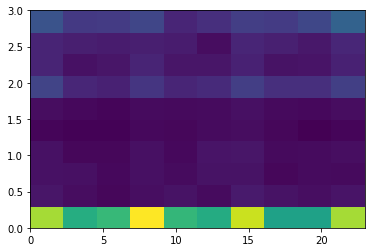

In [40]:
plt.hist2d(weather.dropna().hour.values, weather.dropna().clouds.values);

### Question 11

Why is the `clouds` column alone not a good indicator for the solar panel output?

Answer this question in max. 50 words and assign your string answer to the variable `question_clouds`.

In [41]:
#// BEGIN_TODO [Q11]
question_clouds = 'The position of the sun is also important, in the summer there is more sun exposure than in winter. Also at night there will be no production if there are no clouds.'
#// END_TODO [Q11]

While the `clouds` column alone may not be sufficient for predicting the solar planel output, it can be used in combination with other features. Therefore, one way of improving the simple linear model could be to extend it with more features. You can gain insight into which features could be relevant by plotting the relationship between the features and the labels.

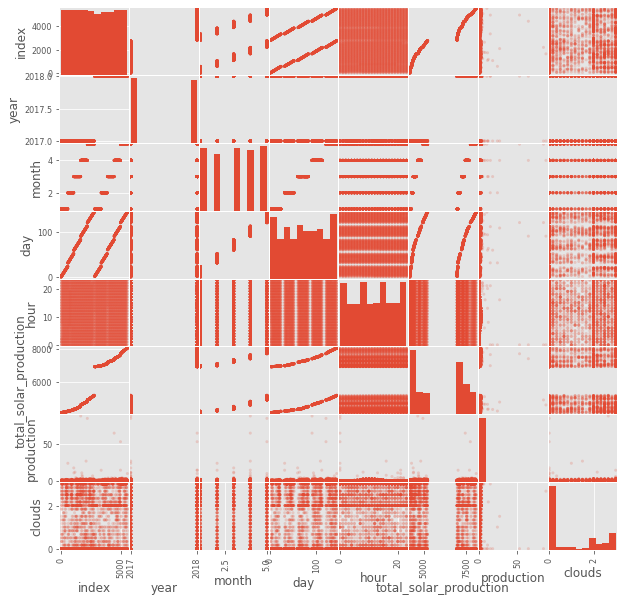

In [42]:
# TODO: use the scatter matrix graph to explore the relationship between the features
from pandas.plotting import scatter_matrix
plt.style.use('ggplot')
scatter_matrix(data, alpha=0.2, figsize=(10, 10))
plt.show()

### Question 12 ###

Which features are most promising for predicting the solar panel output? Select two most promising features:

- `'year'`
- `'month'`
- `'day'`
- `'hour'`
- `'air pressure'`
- `'humidity'`
- `'visibility'`
- `'wind speed'`
- `'temperature'`

Assign a list of strings corresponding to the promising features to variable `question_features`.

In [43]:
#// BEGIN_TODO [Q12]
question_features = ['day', 'hour']
#// END_TODO [Q12]

Note that using additional features may require aggregating them per hour. The `clouds` feature was aggregated taking the maximum value within a given hour, but this may not be suitable for all features.

### Question 13 ###

Using your new-found knowledge of the features, re-define the data on which you train and evaluate your model. Try to improve your model as much as possible by only changing the selection of features.

Assign your new data, new model and the corresponding MAD score to the variables `improved_data`, `improved_model`, `improved_mad`, respectively.

In [44]:
#// BEGIN_TODO [Q13]
improved_data = data
X = improved_data[["day"]].values
y = improved_data["production"].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
improved_model = LinearRegression().fit(X_train, y_train)
y_pred = improved_model.predict(X_test)
improved_mad = mean_absolute_error(y_test, y_pred)
print(improved_mad)
improved_model.score(X_test, y_test)
#// END_TODO [Q13]

0.5063736873599392


0.007326049477396568

#### Choose a more or less flexible model

Another way is to add flexibility to the model e.g. by changing it to a polynomial model or a neural network. You can read more about simple extensions of the linear model in Section 3.3.2 and 6.2 of "Introduction to Statistical Learning".

[ 0  0  0 ... 58  0  0]
continuous
multiclass
multiclass
0.7432697014194811         0.5957446808510638
normal
accuracy: 0.5957446808510638
precision: 0.5957446808510638
recall: 0.5957446808510638
f1: 0.5957446808510638
0.737151248164464         0.5935436537050623
normal
accuracy: 0.5935436537050623
precision: 0.5935436537050623
recall: 0.5935436537050623
f1: 0.5935436537050623
0.7048458149779736         0.5964783565663977
normal
accuracy: 0.5964783565663977
precision: 0.5964783565663977
recall: 0.5964783565663977
f1: 0.5964783565663977
0.6857562408223201         0.5957446808510638
normal
accuracy: 0.5957446808510638
precision: 0.5957446808510638
recall: 0.5957446808510638
f1: 0.5957446808510638
0.6642192853646598         0.586940572267058
normal
accuracy: 0.586940572267058
precision: 0.586940572267058
recall: 0.586940572267058
f1: 0.586940572267058
0.6536955457660304         0.5906089508437271
normal
accuracy: 0.5906089508437271
precision: 0.5906089508437271
recall: 0.5906089508437271


Text(0.5, 1.0, 'metrics vs true weight')

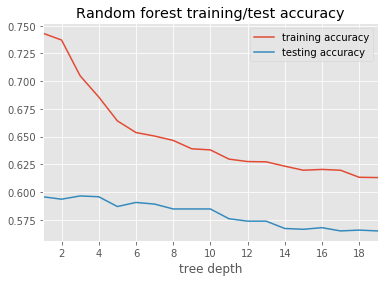

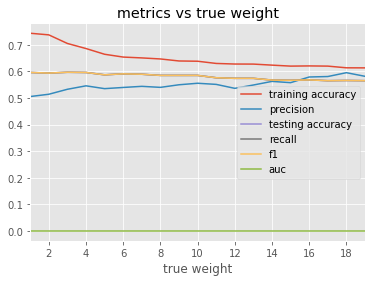

In [46]:
# TODO: explore other models for predicting the solar panel output and evaluate their perfromance in terms of R2 score and mean absolute deviation

from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
import scikitplot as skplt
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from sklearn import preprocessing
from sklearn import utils

scores_accuracy = []
scores_precision = []
scores_recall = []
scores_f1 = []
scores_auc = []
trainscores = []
X = data[["hour", "day", "month", "clouds"]].values
y = data["production"].values

lab_enc = preprocessing.LabelEncoder()
y_encoded = lab_enc.fit_transform(y)
print(y_encoded)
print(utils.multiclass.type_of_target(y_train))
print(utils.multiclass.type_of_target(y_train.astype('int')))
print(utils.multiclass.type_of_target(y_encoded))

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.25)

def print_results(headline, true_value, pred):
    print(headline)
    print("accuracy: {}".format(accuracy_score(true_value, pred)))
    #print("accuracy: {}".format(accuracy_score(true_value, pred)))
    print("precision: {}".format(precision_score(true_value, pred, average='micro')))
    scores_precision.append((precision_score(true_value, pred, average='weighted', zero_division=0)))
    print("recall: {}".format(recall_score(true_value, pred, average='micro')))
    scores_recall.append((recall_score(true_value, pred, average='micro')))
    print("f1: {}".format(f1_score(true_value, pred, average='micro')))
    scores_f1.append((f1_score(true_value, pred, average='micro')))
#     print("auc: {}".format(roc_auc_score(true_value, pred)))
#     scores_auc.append((roc_auc_score(true_value, pred, average='micro')))
    scores_auc.append(0.0)

for i in range (1,20):
    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
    #X_train, y_train = make_classification(n_samples=1000, n_features=3031,
    #                       n_informative=2, n_redundant=0,
    #                       random_state=0, shuffle=False)
    weights = {False: 1, True: i}
    clf = RandomForestClassifier(n_estimators=100, max_depth=9, random_state=0, class_weight=weights)
    clf.fit(X_train, y_train)
    trainscore = clf.score(X_train, y_train)
    testscore = clf.score(X_test, y_test)
    trainscores.append(trainscore)
    scores_accuracy.append(testscore)

    print(repr(trainscore) + '         ' + repr(testscore) )
    y_pred = clf.predict(X_test)
    # Compute confusion matrix
#     cnf_matrix = confusion_matrix(y_test, y_pred)
#     np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
# #     plt.figure()
# #     plot_confusion_matrix(cnf_matrix, classes=class_names, title='C' + str(i))
#     #plt.savefig('./plot/knearestneighbor/confusionmatrix-'+str(n_neighbors)+'.png')
#         # Plot normalized confusion matrix
#     plt.figure()
#     plot_confusion_matrix(cnf_matrix,classes=class_names, normalize=True, title='Normalized confusion matrix true weight:' + str(i))

#     #plt.savefig('./plot/knearestneighbor/confusionmatrix-'+str(n_neighbors)+'.normalized.png')
#     plt.show()

#     y_probas = clf.predict_proba(X_test)

#     skplt.metrics.plot_roc(y_test, y_probas, title='ROC Curve true weight:' + str(i))
#     #plt.savefig('./plot/knearestneighbor/roc-'+str(n_neighbors)+'.png')
#     plt.show()

    print_results("normal", y_test, y_pred)
    
print('mean test score')
print(np.mean(trainscores))
#print(scores)

# X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25)


#plot scores of training data
import matplotlib.pyplot as plt
results = pd.DataFrame(data = {'training accuracy': trainscores, 'testing accuracy': scores_accuracy, "tree depth": range(1,20)})
results.plot(x="tree depth")
plt.title("Random forest training/test accuracy")
results = pd.DataFrame(data = {'training accuracy': trainscores, 'precision': scores_precision, 'testing accuracy': scores_accuracy, 'recall': scores_recall, 'f1': scores_f1, 'auc': scores_auc, "true weight": range(1,20)})
results.plot(x="true weight")
plt.title("metrics vs true weight")

### Simulate the forecasting

The `weather_test.csv` file contains the weather data that was held out from `weather_train.csv` used for training the solar panel output predictor. This data simulates the weather forcasts and is used for evaluating how your model would perform if it was deployed.

In [50]:
weather_test = pd.read_csv('./data/weather_test.csv')
weather_test.head()

,time,clouds,temperature,humidity,wind direction,wind speed,visibility,air pressure,year
0,2017-01-25T00:00:00Z,0,-0.3,91.0,OZO,1.0,3170.0,1031.2,2017
1,2017-01-25T00:10:00Z,0,-0.4,90.0,O,2.0,3160.0,1031.2,2017
2,2017-01-25T00:20:00Z,0,-0.4,90.0,OZO,2.0,2970.0,1031.1,2017
3,2017-01-25T00:30:00Z,0,-0.3,91.0,ZZO,2.0,2940.0,1031.0,2017
4,2017-01-25T00:40:00Z,0,-0.3,90.0,ZO,1.0,2980.0,1031.0,2017


Provide the predictions for the hourly solar panel output for the given weather forecasts, i.e. populate the `production` column in the following data frame:

In [69]:
prediction = weather_test.copy()
times = pd.to_datetime(prediction["time"])
prediction['month'] = times.dt.month
prediction['day'] = times.dt.dayofyear
prediction['hour'] = times.dt.hour
prediction = prediction.drop(prediction[prediction['hour'] == 0].index)
prediction = prediction[['month', 'day', 'hour']]
prediction = prediction.drop_duplicates().reset_index(drop=True)
prediction['production'] = np.nan
prediction.head()

,month,day,hour,production
0,1,25,1,NaN
1,1,25,2,NaN
2,1,25,3,NaN
3,1,25,4,NaN
4,1,25,5,NaN


**Important:** your model will be evaluated on the held out test set. It is therefore safe to train your *final* model on the entire data set that was provided (rather than the X_train, y_train subsets from the train/test split above), to capture all of the information that is available to you.

### Question 14

Fill in the `'production'` column in the prediction data frame with your predictions (do not reorder the rows). Assign the values from the `'production`' column as a Python list to the variable `forecast`.

In [75]:
#// BEGIN_TODO [Q14]

prediction['production'] = prediction.apply(
    lambda row: clf.predict([[row['hour'], row['day'], row['month'], 0]]),
    axis=1
)
#// END_TODO [Q14]

For automating the evaluation of your predictions, call the evaluate function that is defined in the `evaluate.py` script (do not edit the code lines below!):

In [72]:
from evaluate_stub import *
evaluate(prediction)

'This is a stub for the evaluation function. The real implementation will compare your predictions with the held out production measurements.'

As a sanity check, make sure that the `prediction` data frame contains a `production` column and 805 rows.

Your solution will be evaluated based on the mean absolute error metric.

### Reliability

We often assume that the trained model will operate on data from the same distribution as the data it was trained on (see Chapter 1 of the book "Dataset Shift in Machine Learning"). However, sometimes these assumptions are not true.

Using the model you trained for question 13, evaluate the model's performance on the data set provided below. It contains the weather, production and consumption data for the year 2019, preprocessed into a single .csv file.

In [88]:
weather_energy = pd.read_csv('./data/weather_energy_2019.csv')
weather_energy.head()

,index,year,month,day,hour,production,consumption,clouds,temperature,humidity,wind speed,visibility,air pressure
0,35,2019,1,2,10,0.3,3.215163,0.0,35.768333,76.500000,4.500000,20050.000000,1037.650000
1,36,2019,1,2,11,0.3,3.982344,0.0,35.621667,75.833333,4.666667,20283.333333,1037.550000
2,37,2019,1,2,12,0.3,3.550910,0.0,35.383333,72.333333,5.000000,19133.333333,1037.433333
3,38,2019,1,2,13,0.2,3.372008,0.0,35.530000,73.833333,4.833333,15700.000000,1037.616667
4,39,2019,1,2,14,0.2,3.838542,0.5,35.713333,71.500000,3.833333,16350.000000,1037.883333


In [95]:
# TODO: Evaluate the model from previous question on the new data
import pandas
pandas.set_option('display.max_rows', 805)
print(prediction)

     month  day  hour production
0        1   25     1        [0]
1        1   25     2        [0]
2        1   25     3        [0]
3        1   25     4        [0]
4        1   25     5        [0]
5        1   25     6        [0]
6        1   25     7        [1]
7        1   25     8        [1]
8        1   25     9        [1]
9        1   25    10        [1]
10       1   25    11        [1]
11       1   25    12        [1]
12       1   25    13        [1]
13       1   25    14        [1]
14       1   25    15        [1]
15       1   25    16        [0]
16       1   25    17        [0]
17       1   25    18        [0]
18       1   25    19        [0]
19       1   25    20        [0]
20       1   25    21        [0]
21       1   25    22        [0]
22       1   25    23        [0]
23       1   26     1        [0]
24       1   26     2        [0]
25       1   26     3        [0]
26       1   26     4        [0]
27       1   26     5        [0]
28       1   26     6        [0]
29       1

### Question 15

Investigate and then explain in at most 100 words in `question_change` what you think is responsible for the change in your model's performance.

In [96]:
# TODO: Investigate changes
X_test_test = weather_energy[["hour", "day", "month", "clouds"]]
y_test_test = weather_energy[["production"]]
lab_enc = preprocessing.LabelEncoder()
y_encoded_test = lab_enc.fit_transform(y_test_test)
print(clf.score(X_test, y_test))
print(clf.score(X_test_test, y_encoded_test))

c:\program files\python\python38\lib\site-packages\sklearn\preprocessing\_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.5649303008070433
0.5311596530677802


In [ ]:
#// BEGIN_TODO [Q15]
question_change = "because the model is not trained on the second half of the year"
#// END_TODO [Q15]

### Question 16

To make your model robust to these kind of changes, you may want to re-train it on more appropriate data. Using all the data you have been provided so far, compose more suitable training and test data sets, and assign them to `new_training_data` and `new_test_data`, respectively.

In [ ]:
#// BEGIN_TODO [Q16]
#// END_TODO [Q16]

### Predicting consumption

Besides solar production, we are also interested in predicting energy consumption. Being able to accurately predict the power bill may save us from any surprises in the future. 

### Question 17

Consumption may depend on other factors than production, so we may need to reconsider the features we chose in question 12. Considering the new training target, which two features from question 12 are most promising for the prediction of energy consumption? Assign them to `question_consumption_features`.

In [97]:
#// BEGIN_TODO [Q17]
question_consumption_feature = ['day', 'hour']
#// END_TODO [Q17]

Train and evaluate your new model on the data in `data` (do not include the data from `weather_energy`) to predict the energy consumption.

In [ ]:
# TODO: Train a new model to predict energy consumption

### Question 18

As in question 15, check this new model's performance when predicting the energy consumption for the data in `weather_energy`. Is there a shift taking place in the data underlying the model? If so, what kind of shift do you think it is? Assign your answer to `question_consumption_shift`.

1. Sample covariate shift
2. Source component shift
3. No shift

In [ ]:
#// BEGIN_TODO [Q18]
question_consumption_shift = 2
#// END_TODO [Q18]

# Feedback

Please fill in this questionaire to help us improve this course for the next year. Your feedback will be anonymized and will not affect your grade in any way!

### How many hours did you spend on these Exercises?

Assign a number to `feedback_time`.

In [ ]:
#// BEGIN_TODO [Feedback_1]
feedback_time = 40
#// END_TODO [Feedback_1]

### How difficult did you find these Exercises?

Assign an integer to `feedback_difficulty`, on a scale 1 - 10, with 1 being very easy.

In [ ]:
#// BEGIN_TODO [Feedback_2]
feedback_difficulty = 7
#// END_TODO [Feedback_2]

### Did you take the course Foundations of Data Mining?

Assign a boolean value to `feedback_foundations` (True or False).

In [ ]:
#// BEGIN_TODO [Feedback_3]
feedback_foundations = False
#// END_TODO [Feedback_3]

### Did you do any other Machine Learning-related coursework (university/workshop/online/etc)

Assign an answer to `feedback_other`, describing any other coursework done.

In [ ]:
#// BEGIN_TODO [Feedback_4]
feedback_other = 'One of us took the bachelor course web analytics.'
#// END_TODO [Feedback_4]

### (Optional) What did you like?

Assign a string to `feedback_like`.

In [ ]:
#// BEGIN_TODO [Feedback_5]
feedback_like = 'everything'
#// END_TODO [Feedback_5]

### (Optional) What can be improved?

Assign a string to `feedback_improve`.

In [ ]:
#// BEGIN_TODO [Feedback_6]
feedback_improve = 'cleaning'
#// END_TODO [Feedback_6]